<a href="https://colab.research.google.com/github/vectice/vectice-examples/blob/master/Notebooks/Vanilla/Tutorial/Tutorial_Modelling_All.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

## 1- Go to the project documentation and create a stage in which you describe the objective of this notebook

Welcome to the Vectice tutorial notebook!


Through this notebook, we will be illustrating how to log the following information into Vectice using the Vectice SDK:
- Dataset versions
- Model versions
- Runs 

For more information on the tutorial, please refer to the "Vectice Tutorial Page" inside the app.



### Install Vectice and GCS packages

In [28]:
## Requirements
!pip3 install --q fsspec
!pip3 install --q gcsfs

#Install Vectice SDK 
!pip3 install --q vectice

In [29]:
#Verify if Vectice SDK was installed
!pip3 show vectice

Name: vectice
Version: 0.15.0
Summary: Vectice Python library
Home-page: https://github.com/vectice/vectice-python
Author: Vectice Inc.
Author-email: sdk@vectice.com
License: Apache License 2.0
Location: /srv/conda/envs/notebook/lib/python3.7/site-packages
Requires: python-dotenv, atlassian-python-api, requests, GitPython, PyGithub, python-gitlab
Required-by: 


### Retrieve the data from GCS

We are going to load data stored in Google Cloud Storage, that is provided by Vectice for this tutorial.


In [30]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Double check the json file name below so that it matches the name of the file that you uploaded.
# Note that the key provided for this tutorial does not have permissions for you to write to GCS. 
# You can only use it to read the data.
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'readerKey.json'

# Once your file is loaded you can view your dataset in a Pandas dataframe.
df = pd.read_csv('gs://vectice_tutorial/kc_house_data_cleaned.csv')

# Run head to make sure the data was loaded properly
df.head()


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503



We will use the scikit-learn library for modeling and tracking experiments directly through the Vectice SDK.

In [31]:
#Import the Vectice library
from vectice import Vectice
from vectice.models import JobType
from vectice.entity.model import ModelType
# Specify the API endpoint for Vectice. This shouldn't change.
os.environ['VECTICE_API_ENDPOINT']= "beta.vectice.com"


# To use the Vectice SDK, you first need to authenticate your account using an API key.
# You can generate an API key from the Vectice UI, by going to the "API Tokens" tab in your workspace

# Copy and paste your API key here
os.environ['VECTICE_API_TOKEN'] = "API TOKEN"

# Next, you need to specify the tutorial project, where you will log the assets that will be generated in this notebook. 
# For this, you need a "Project Token", that you will find under the "Settings" tab of your project

# Copy and paste your Project Token here
vectice = Vectice(project_token="Project Token")

print(vectice)

### Split dataset into training and testing

Let's split the dataset into train and test sets and save them in GCS.
(The GCS code has been commented out as the data has already been generated.)



## 2- Create another stage in the project documentation in which you describe the split data part and upload the original run as well as the input and the output datasets of this run

Testing the model on the same data as it was trained on will lead to an overfit and poor performance in real-life scenarios.
In order to avoid that, we split our data into 2 pieces: train set and test set. The most common practice is to do a 80-20 split.

In [32]:
import string
from math import sqrt

# Load scikit-learn packages
from sklearn.model_selection import train_test_split  # Model Selection
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Model Evaluation
from sklearn.linear_model import LinearRegression  # Linear Regression
from sklearn.tree import DecisionTreeRegressor, plot_tree  # Decision Tree Regression
from sklearn.ensemble import RandomForestRegressor  # Random Forest Regression


In [33]:
# The Vectice SDK automatically detects if there have been changes to the dataset you are using.
# If it detects changes, it will generate a new version of your dataset automatically. 
# For this tutorial, we changed the data since Albert left the company.
# So, the SDK will create a new dataset version the first time you execute this code.

input_ds_version = vectice.create_dataset_version().with_parent_name("cleaned_kc_house_data")


# With this line we declare a reference to code existing in GitHub as the code at the origin of the outputs
input_code = Vectice.create_code_version_with_github_uri("https://github.com/vectice/vectice-examples",
                        "Notebooks/Vanilla/Tutorial/Tutorial_Modelling_All.ipynb") 



# Each execution for a given job is called a run. When creating a run you need to specify:
# 1) a job name (mandatory)
# 2) a job type (optional)
# Job names and job types are useful to group and search runs in the Vectice UI.
# For this run, we will use the job name "80/20 Split" and the job type "PREPARATION"
vectice.create_run("80/20 Split", JobType.PREPARATION)
#Start the run
## Using the with method end the run automatically. We don't need to add vectice.end_run(outputs=outputs) to end the run
with vectice.start_run(inputs=[input_ds_version,input_code]) as run:

# We will use an 80/20 split to prepare the data
    test_size = 0.2

# We will set the random seed so we always generate the same split.
    random_state = 42

    train, test = train_test_split(df, test_size = test_size, random_state = random_state)

# We commented out the code to persist the training and testing test in GCS, 
# because we already generated the data for you.
# The key provided for this tutorial give you read access only to GCS.
# We left the code below for convenience, in case you want to use your own credentials and GCS bucket.
# train.to_csv (r'gs://vectice_tutorial/training_data.csv', index = False, header = True)
# test.to_csv (r'gs://vectice_tutorial/testing_data.csv', index = False, header = True)

# Generate X_train, X_test, y_train, y_test, which we will need for modeling
    X = df.drop("price", axis=1).values
    y = df["price"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)


# Let's create new versions of the training and testing dataset if the data has changed.
# We will use the existing dataset created by Albert, so that we can append new 
# dataset versions to it.
    train_ds_version = vectice.create_dataset_version().with_parent_name("train_cleaned_kc_house_data")
    test_ds_version = vectice.create_dataset_version().with_parent_name("test_cleaned_kc_house_data")

# Attach the output datasets to the run.
    run.add_outputs([train_ds_version,test_ds_version])

# We can preview one of our generated outputs to make sure that everything was executed properly.
X_train


array([[ 4.00000e+00,  3.00000e+00,  3.61000e+03, ..., -1.22342e+02,
         3.56800e+03,  1.89480e+04],
       [ 3.00000e+00,  2.00000e+00,  2.08000e+03, ..., -1.22285e+02,
         1.92000e+03,  7.00000e+03],
       [ 4.00000e+00,  2.50000e+00,  2.09000e+03, ..., -1.22221e+02,
         1.51000e+03,  7.40200e+03],
       ...,
       [ 3.00000e+00,  1.00000e+00,  1.46000e+03, ..., -1.22191e+02,
         1.15000e+03,  5.92600e+03],
       [ 3.00000e+00,  2.25000e+00,  1.62000e+03, ..., -1.22137e+02,
         1.60000e+03,  7.91000e+03],
       [ 4.00000e+00,  3.50000e+00,  3.38000e+03, ..., -1.22379e+02,
         2.22000e+03,  8.33000e+03]])

### Name your experiments

Input the experiment names and make them unique

In [34]:
# Let's define a helper function that we will use to generate unique model version names.
# We will make the model version name optional in a future edition of the Vectice SDK
# so this function won't be necessary anymore.
import random

def get_random_string(length):
    return "".join(random.choice(string.ascii_letters) for i in range(length))


## 3-Add a stage about the modeling part in which you describe the different used models upload the original run as well as the input datasets and the output model version of each run. You can also add the output pictures of these models or upload the notebook and extract the images. 

## Modeling

### Linear regression model

Regression is a method of modelling a target value based on independent predictors. This method is mostly used for forecasting and finding out cause and effect relationship between variables. Regression techniques mostly differ based on the number of independent variables and the type of relationship between the independent and dependent variables.

First, we will do a basic Linear Regression and observe the baseline accuracy metrics.

In [38]:
# Each execution for a given job is called a run, for LR we will only do one run.
# Setting a job's name is mandatory when starting a run 
# and is useful to group and search runs in the Vectice UI.

# Linear regression model training
vectice.create_run("LR-Model", JobType.TRAINING)
## Start the run
## Using the with method end the run automatically. We don't need to add vectice.end_run(outputs=outputs) to end the run
with vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code]) as run:

    lr_rg = LinearRegression()
    lr_rg.fit(X_train, y_train)
    lr_pred = lr_rg.predict(X_test)

# Evaluate Metrics
    MAE = mean_absolute_error(lr_pred, y_test)
    RMSE = sqrt(mean_squared_error(lr_pred, y_test))

    print("Root Mean Squared Error: ", RMSE)
    print("Mean Absolute Error: ", MAE)

# Let's log the model we trained along with its metrics, as a new version 
# of the "Regressor" model in Vectice.
# Note that we used a random string to have a unique model version name in Vectice. 
## Here we create our model version.
## We can declare the model type using the .with_type method
    model_version = vectice.create_model_version().with_parent_name("Regressor").with_type(ModelType.REGRESSION).with_algorithm("Linear Regression").with_metric("RMSE",RMSE).with_metric("MAE",MAE).with_user_version(get_random_string(12))
## Attach the model version to the run
    run.add_outputs(outputs=[model_version])


Root Mean Squared Error:  156149.06199382254
Mean Absolute Error:  109761.97924258617


### Decision tree model

A decision tree is an upside-down tree that makes decisions based on the conditions present in the data.
Decision Tree algorithm has become one of the most used machine learning algorithm both in competitions like Kaggle as well as in business environment. Decision Tree can be used both in classification and regression problem. A decision tree is arriving at an estimate by asking a series of questions to the data, each question narrowing our possible values until the model get confident enough to make a single prediction. The order of the question as well as their content are being determined by the model. In addition, the questions asked  are all in a True/False form

In this section let's use the decision tree algorithm and compare the accuracy to the logistic regression algorithm. We will try different values for the tree_depth. We will log the model parameters and metrics in Vectice.

Root Mean Squared Error: 144649.5566489278
Mean Absolute Error: 95872.63972094451


4829

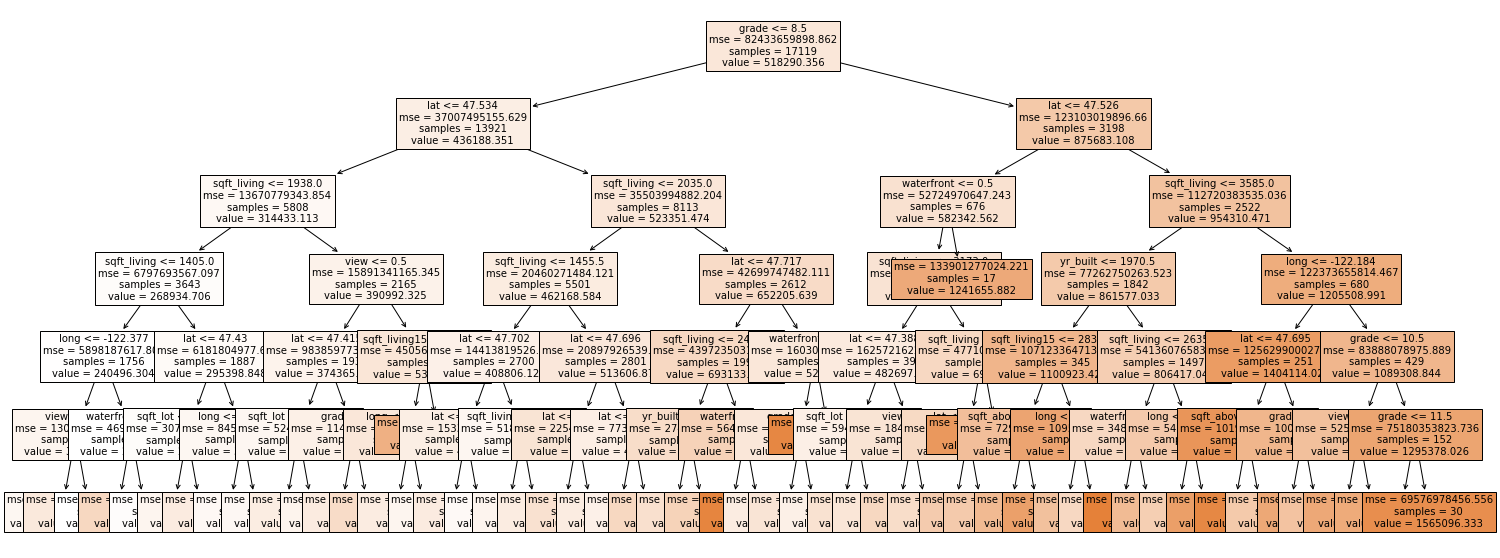

In [39]:
# We can do a few runs with different max depth for the tree.
# Just change the value below and re-run this cell.
# The model versions you created will show up in the Vectice UI as new versions 
# of the "Regressor" Model. You can easily compare them from there.
tree_depth = 6

vectice.create_run("DT-Model", JobType.TRAINING)
## Start the run
vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code])

dtr = DecisionTreeRegressor(max_depth=tree_depth, min_samples_split=50)
dtr.fit(X_train,y_train)
dtr_pred = dtr.predict(X_test) 

data_feature_names = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                      'waterfront', 'view', 'condition', 'grade', 'sqft_above',
                      'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
                      'long', 'sqft_living15', 'sqft_lot15']

# Visualize the Decision Tree Model
plt.figure(figsize=(25, 10))
plot_tree(dtr, feature_names=data_feature_names, filled=True, fontsize=10)

MAE = mean_absolute_error(dtr_pred, y_test)
RMSE = sqrt(mean_squared_error(dtr_pred, y_test))

print("Root Mean Squared Error:", RMSE)
print("Mean Absolute Error:", MAE)
## Here we create our model version.
## We can declare the model type using the .with_type method
model_version = vectice.create_model_version().with_parent_name("Regressor").with_type(ModelType.REGRESSION).with_algorithm("Decision Tree").with_property("Tree Depth",str(tree_depth)).with_metric("RMSE",RMSE).with_metric("MAE",MAE).with_user_version(get_random_string(12))
## Here we should end the run and attach the created model version to it since we don't use the with method
vectice.end_run(outputs=[model_version])

### Random forest model

Let's use the Random Forest Regression and do some hyper-parameter tuning on it.

Random Forest is also a “Tree”-based algorithm that uses the qualities features of multiple Decision Trees for making decisions
Therefore, it can be referred to as a ‘Forest’ of trees and hence the name “Random Forest”. The term ‘Random’ is due to the fact that this algorithm is a forest of ‘Randomly created Decision Trees’.
The Decision Tree algorithm has a major disadvantage in that it causes over-fitting. This problem can be limited by implementing the Random Forest Regression in place of the Decision Tree Regression. Additionally, the Random Forest algorithm is also very fast and robust than other regression models.

In [40]:
# You can modify the parameters below and execute multiple runs to train 
# different versions of RF model.
nb_trees = 60
min_samples = 30

vectice.create_run("RF-Model", JobType.TRAINING)
## Start the run
## Using the with method end the run automatically. We don't need to add vectice.end_run(outputs=outputs) to end the run
with vectice.start_run(inputs=[train_ds_version,test_ds_version,input_code]) as run:

    rf_regressor = RandomForestRegressor(n_estimators=nb_trees, min_samples_leaf=min_samples)
    rf_regressor.fit(X_train, y_train)
    rf_regressor.score(X_test, y_test)
    rf_regressor_pred = rf_regressor.predict(X_test)

    MAE = mean_absolute_error(rf_regressor_pred, y_test)
    RMSE = sqrt(mean_squared_error(rf_regressor_pred, y_test))

    print("Root Mean Squared Error:", RMSE)
    print("Mean Absolute Error:", MAE)

# Here's an alternative version to declare metrics
    metrics = [("RMSE",RMSE), ("MAE",MAE)]
## Here we create our model version.
## We can declare the model type using the .with_type method
    model_version = vectice.create_model_version().with_parent_name("Regressor").with_type(ModelType.REGRESSION).with_algorithm("Random Forest").with_property("nb_trees",str(nb_trees)).with_property("min_samples",str(min_samples)).with_metrics(metrics).with_user_version(get_random_string(12))
##Attach the created model version to the run
    run.add_outputs(outputs=[model_version])


/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the re

Root Mean Squared Error: 115799.9910783733
Mean Absolute Error: 73347.77027186584


We can see that the Random Forest Regressor model gives the lowest error and should be the preferred approach despite the complexity of the algorithm. Let's get the list of features' importance to discuss which variables are influencing the model the most.

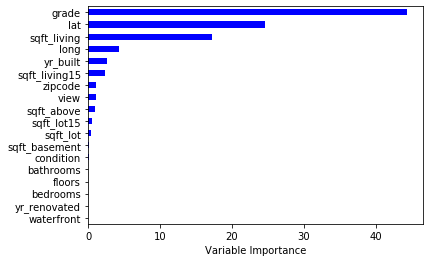

In [41]:
columns = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
           'waterfront', 'view', 'condition', 'grade', 'sqft_above',
           'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
           'long', 'sqft_living15', 'sqft_lot15']

importance = pd.DataFrame({'Importance': rf_regressor.feature_importances_ * 100}, index=columns)
importance.sort_values(by="Importance", axis=0, ascending=True).plot(kind="barh", color="b")
plt.xlabel("Variable Importance")
plt.gca().legend_ = None


Thank you and congratulations! You have succesfully completed the notebook part of the tutorial.

In this notebooks we have illustrated how you can capture your experiments, hyper-parameters, dataset versions and metrics using Vectice SDK. 
You can now leverage Vectice UI for analysis, documentation and to engage a business conversation around the findings.

Vectice enables you to:
1. Make your experiments more reproducible.
2. Track the data and code that is used for each experiment and model versions.
3. Document your projects' progress and collaborate with your team in Vectice's UI.
4. Discover previous work and reuse your team knowledge for new projects.

We are constantly improving the Vectice SDK and the Vectice application. Let us know what improvements you would like to see in the solution and what your favorite features are after completing this tutorial. 

Feel free to explore more and come up with your own ideas on how to best start leveraging Vectice!
